In [ ]:
# Cora dataset

In [1]:
!pip install torch_geometric

# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cu122.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu122.html
ERROR: Could not find a version that satisfies the requirement pyg_lib (from versions: none)
ERROR: No matching distribution found for pyg_lib


In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures


In [4]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')

print(f'Dataset: {dataset}')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...


Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7


Done!


In [7]:
data = dataset[0]
print(data)

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556


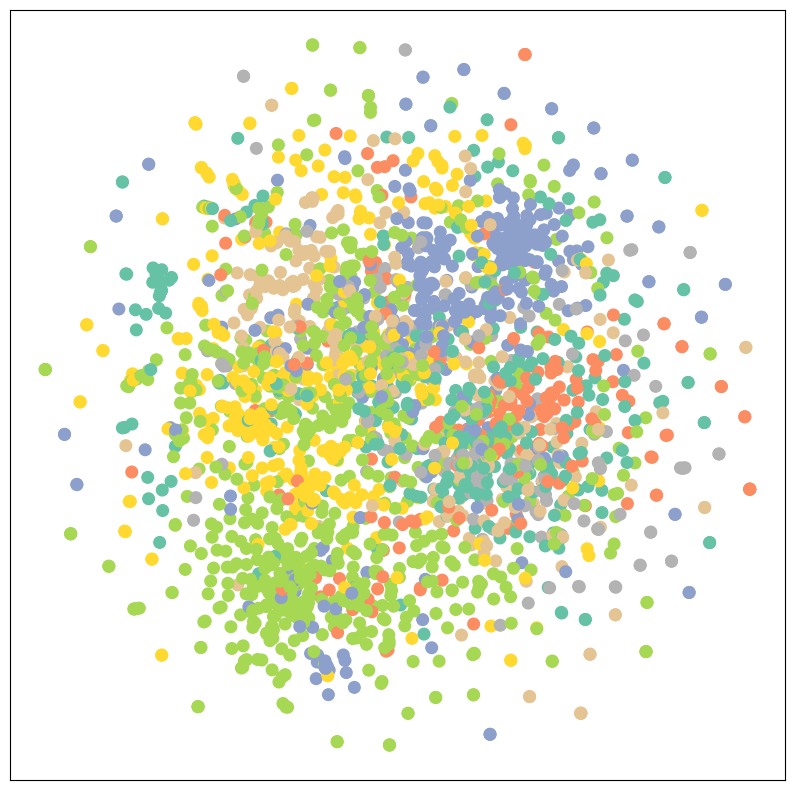

In [8]:
# 可视化部分
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

visualize(data.x, data.y)




In [12]:
# first try MLP
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(12345)
    self.lin1 = Linear(dataset.num_features, hidden_channels)
    self.lin2 = Linear(hidden_channels, dataset.num_classes)

  def forward(self, x):
    x = self.lin1(x)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.lin2(x)
    return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [13]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss

def test():
  model.eval()
  out = model(data.x)
  pred = out.argmax(dim=1)
  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
  return test_acc



In [14]:
for epoch in range(200):
  loss = train()
  print(f'Epoch: {epoch}, Loss: {loss}')

Epoch: 0, Loss: 1.9619522094726562
Epoch: 1, Loss: 1.9027512073516846
Epoch: 2, Loss: 1.8414477109909058
Epoch: 3, Loss: 1.7561613321304321
Epoch: 4, Loss: 1.6390373706817627
Epoch: 5, Loss: 1.5613676309585571
Epoch: 6, Loss: 1.4281827211380005
Epoch: 7, Loss: 1.350545048713684
Epoch: 8, Loss: 1.2641708850860596
Epoch: 9, Loss: 1.178624153137207
Epoch: 10, Loss: 1.0886567831039429
Epoch: 11, Loss: 0.9625500440597534
Epoch: 12, Loss: 0.9238315224647522
Epoch: 13, Loss: 0.8176745176315308
Epoch: 14, Loss: 0.7710466980934143
Epoch: 15, Loss: 0.6765591502189636
Epoch: 16, Loss: 0.6483006477355957
Epoch: 17, Loss: 0.5991811156272888
Epoch: 18, Loss: 0.5321783423423767
Epoch: 19, Loss: 0.5321124196052551
Epoch: 20, Loss: 0.4860765039920807
Epoch: 21, Loss: 0.5025644302368164
Epoch: 22, Loss: 0.4680023193359375
Epoch: 23, Loss: 0.42764607071876526
Epoch: 24, Loss: 0.3171105980873108
Epoch: 25, Loss: 0.3860819339752197
Epoch: 26, Loss: 0.3428914546966553
Epoch: 27, Loss: 0.3348960280418396
Epo

In [15]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5830


In [16]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(12345)
    self.conv1 = GCNConv(dataset.num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv2(x, edge_index)
    return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


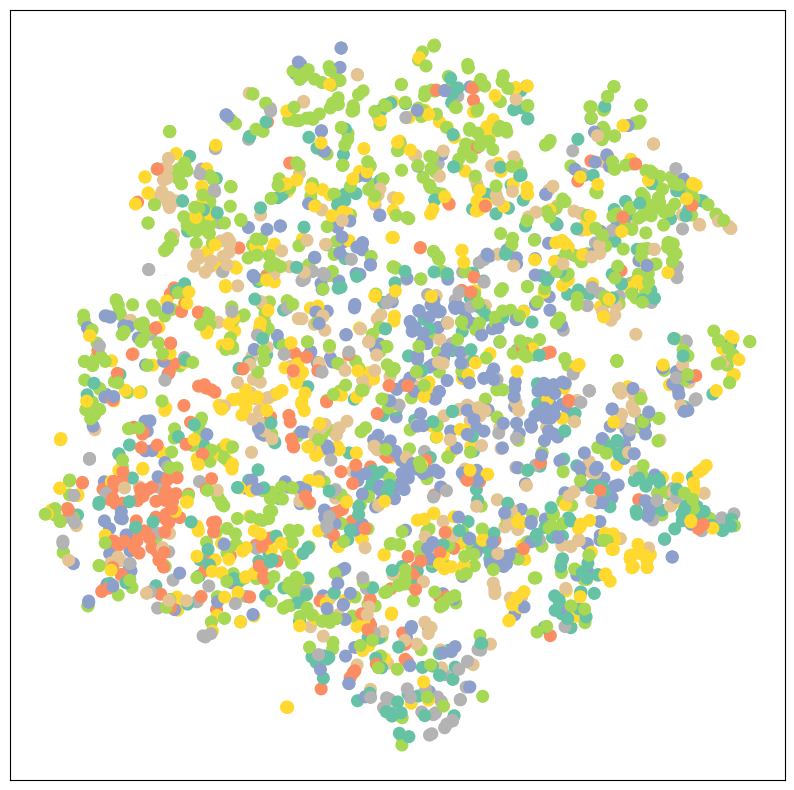

In [19]:
model = GCN(hidden_channels=16)

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [20]:
# 训练模型
model = GCN(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss

def test():
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)
  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
  return test_acc

In [21]:
for epoch in range(200):
  loss = train()
  print(f'Epoch: {epoch}, Loss: {loss}')

Epoch: 0, Loss: 1.947363018989563
Epoch: 1, Loss: 1.8485549688339233
Epoch: 2, Loss: 1.738198161125183
Epoch: 3, Loss: 1.6300392150878906
Epoch: 4, Loss: 1.4890918731689453
Epoch: 5, Loss: 1.3652740716934204
Epoch: 6, Loss: 1.2619251012802124
Epoch: 7, Loss: 1.1164896488189697
Epoch: 8, Loss: 1.00729238986969
Epoch: 9, Loss: 0.9298135042190552
Epoch: 10, Loss: 0.8411919474601746
Epoch: 11, Loss: 0.7436341047286987
Epoch: 12, Loss: 0.6744422316551208
Epoch: 13, Loss: 0.5304504036903381
Epoch: 14, Loss: 0.5116912126541138
Epoch: 15, Loss: 0.4813600182533264
Epoch: 16, Loss: 0.3987997770309448
Epoch: 17, Loss: 0.37284135818481445
Epoch: 18, Loss: 0.352843701839447
Epoch: 19, Loss: 0.32446980476379395
Epoch: 20, Loss: 0.2602041959762573
Epoch: 21, Loss: 0.22137904167175293
Epoch: 22, Loss: 0.22424151003360748
Epoch: 23, Loss: 0.2133360654115677
Epoch: 24, Loss: 0.15895436704158783
Epoch: 25, Loss: 0.17548049986362457
Epoch: 26, Loss: 0.15469583868980408
Epoch: 27, Loss: 0.13458146154880524

In [22]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8020


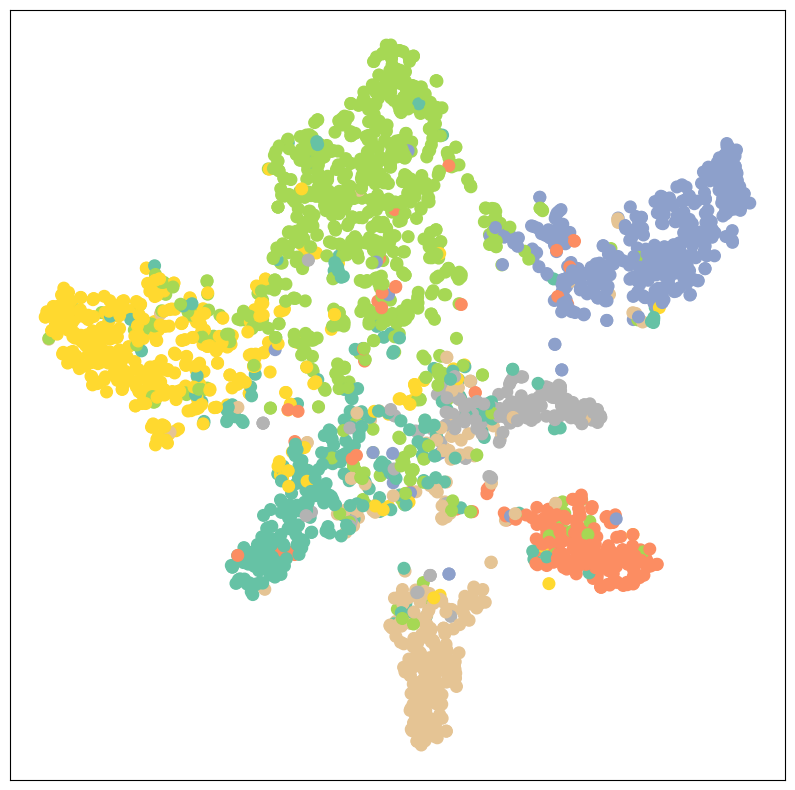

In [24]:
model.eval()

out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)
visualize(out, color=data.y)